In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
import numpy as np
import matplotlib.pyplot as plt
from ML_components import load_params
from Network import NeuralNetwork
import scipy
import torch
from filters import butter_lowpass

In [ ]:
print('Yo, welcome to Main CS')

## Automatic Tests

In [2]:
#symbol_set = [7, 5, 3, 1, -1, -3, -5, -7] # all symbols that we use
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 10


# can never not normalize and not use gain. Either one or both.
decisions = CS.transmission(SNRdb=SNR, mode='joint', v=True)

print("Accuracy:", 1 - CS.evaluate(decisions)[1])

0.8944271909999159
Accuracy: 0.8818


### Manual Test

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1000

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
sigma = 2

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample()
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)#/np.sqrt(gain_factor)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)/gain_factor

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

#1 - CS.evaluate(decisions)[1]

### Manual Test with normalization of signal instead of gain_factor

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 1000

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
symbol_seq_power = np.mean(np.square(symbol_seq))
SNR = 10
sigma = CS.SNRdb_to_sigma(SNR, 8, use_gain=False)
print(sigma)

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Normalize signal with RMS
Tx = Tx / np.sqrt(np.mean(np.square(Tx)))

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)

# Normalize received signal with RMS * squareroot of symbol seq power?
Rx = (Rx / np.sqrt(np.mean(np.square(Rx)))) * np.sqrt(symbol_seq_power)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

1 - CS.evaluate(decisions)[1]

## Display filter

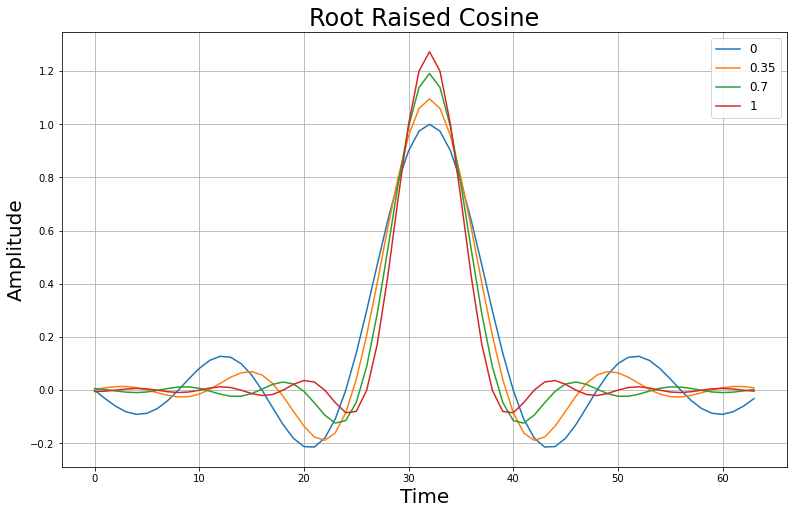

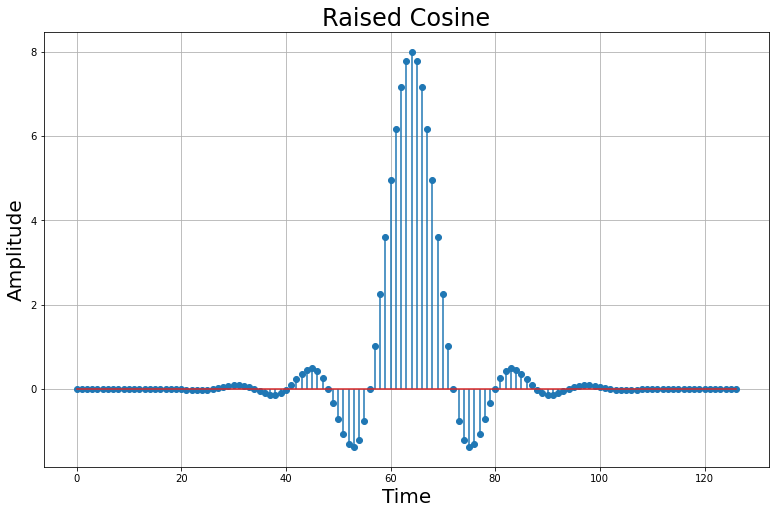

In [3]:
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    #f = np.fft.fft(CS.h)
    plt.plot(CS.h)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
plt.stem(np.convolve(CS.h, CS.h))
plt.grid(True)
plt.show()

____

# Evaluation of pretrained Decision Making models

In [4]:
for i in range(5):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 10000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    SNRdb = 16    
    
    euclid_decs, NN_decs, block_decs, network_decs, joint_decs = CS.transmit_all(SNRdb, joint_cutoff=2)
    

    print('Euclidean Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('NN Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('Block Error Rate: {}%'.format((CS.evaluate(block_decs)[1]*100).round(2)))
    print('Receiver Network Error Rate: {}%'.format((CS.evaluate(network_decs)[1]*100).round(2)))
    print('Joint Sender-Receiver Network Error Rate: {}%'.format((CS.evaluate(joint_decs)[1]*100).round(2)))
    print()

Euclidean Error Rate: 0.35%
NN Error Rate: 0.35%
Block Error Rate: 0.64%
Receiver Network Error Rate: 0.35%
Joint Sender-Receiver Network Error Rate: 0.31%

Euclidean Error Rate: 0.26%
NN Error Rate: 0.26%
Block Error Rate: 0.49%
Receiver Network Error Rate: 0.34%
Joint Sender-Receiver Network Error Rate: 0.33%

Euclidean Error Rate: 0.36%
NN Error Rate: 0.36%
Block Error Rate: 0.39%
Receiver Network Error Rate: 0.36%
Joint Sender-Receiver Network Error Rate: 0.48%

Euclidean Error Rate: 0.47%
NN Error Rate: 0.47%
Block Error Rate: 0.71%
Receiver Network Error Rate: 0.42%
Joint Sender-Receiver Network Error Rate: 0.45%

Euclidean Error Rate: 0.33%
NN Error Rate: 0.33%
Block Error Rate: 0.55%
Receiver Network Error Rate: 0.38%
Joint Sender-Receiver Network Error Rate: 0.28%



### SNR Calculations

In [5]:
SNRdbs, euclid_error_rates, network_error_rates, NN_error_rates, block_error_rates, \
joint_error_rates, error_theory = SNR_plot(num_symbols=1000,
                                           rx_cutoff=None)

Avg symbol energy 4.832
gain 7.997651076371556


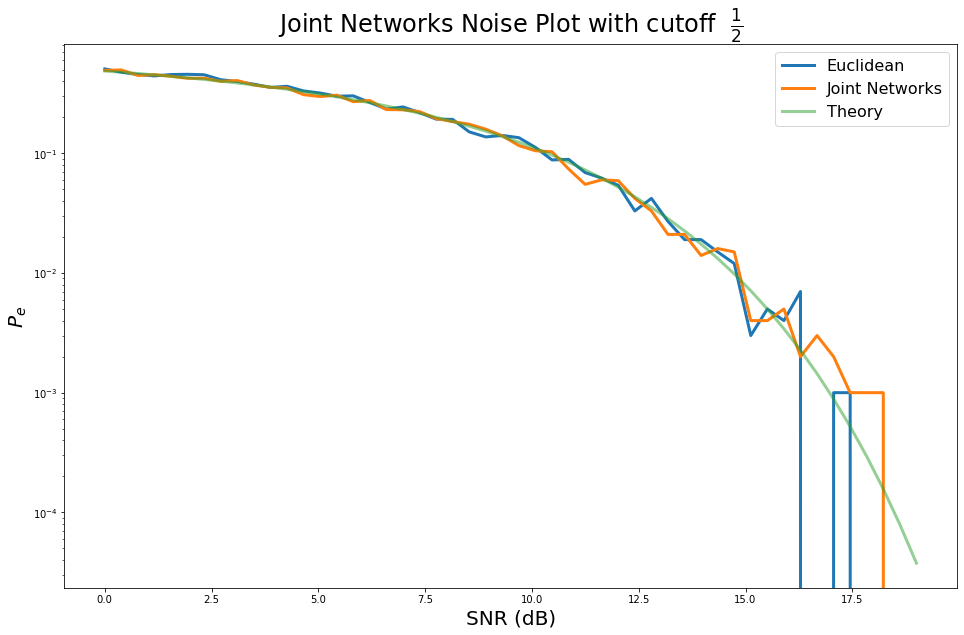

In [6]:
plt.figure(figsize=(16,10))
plt.title('Joint Networks Noise Plot with cutoff  ' r'$\frac{1}{2}$', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRdbs[num:], euclid_error_rates[num:], alpha=1, linewidth=3)
#plt.semilogy(SNRdbs[num:], NN_error_rates[num:])
#plt.semilogy(SNRdbs[num:], block_error_rates[num:])
#plt.semilogy(SNRdbs[num:], network_error_rates[num:], alpha=1, linewidth=3)
plt.semilogy(SNRdbs[num:], joint_error_rates[num:], alpha=1, linewidth=3)
plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=0.5, linewidth=3)
legend1 = ['Euclidean','Joint Networks', 'Theory']
legend2 = ['Euclidean', 'Receiver Network', 'Joint Network', 'Theory']
legend3 = ['Euclidean', 'NN Dec Maker', 'Block', 'Receiver Network', 'Joint Network', 'Theory']
plt.legend(legend1, fontsize=16)
plt.show()

In [7]:
er_for_sigma3 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(3**2))))
er_for_sigma2 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(2**2))))
er_for_sigma1 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(1**2))))
print(1-er_for_sigma1, 1-er_for_sigma2, 1-er_for_sigma3)

0.9964916987642146 0.8820255947122863 0.7406660603866299


# Inspect Decision Boundaries for NN Decision Making

In [8]:
weights, biases, sizes = load_params('../Weights/decision_making_weights.npz',
                                         '../Weights/decision_making_biases.npz')
NN = NeuralNetwork(sizes, startweights=weights, startbiases=biases,
                           type='classification', afunc='relu')
classes = np.array(symbol_set)

## Plot 1

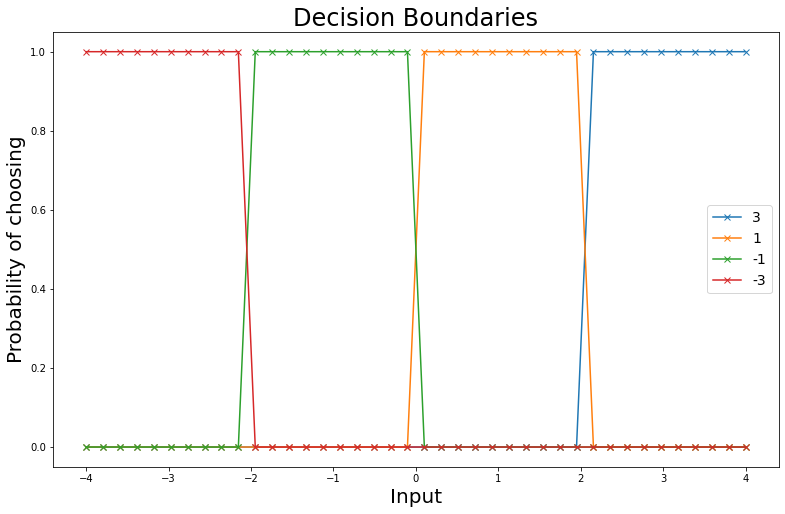

In [9]:
test_seq = np.linspace(-4, 4, 40)
test_seq = np.array(test_seq, ndmin=2).T
yhat_onehot = NN.feedforward(test_seq)


plt.figure(figsize=(13,8))
plt.title('Decision Boundaries', fontsize=24)
for i in range(yhat_onehot.shape[1]):
    plt.plot(test_seq, yhat_onehot[:,i], '-x')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + ['Euclidean Boundaries'], fontsize=14)
plt.show()

## Plot 2

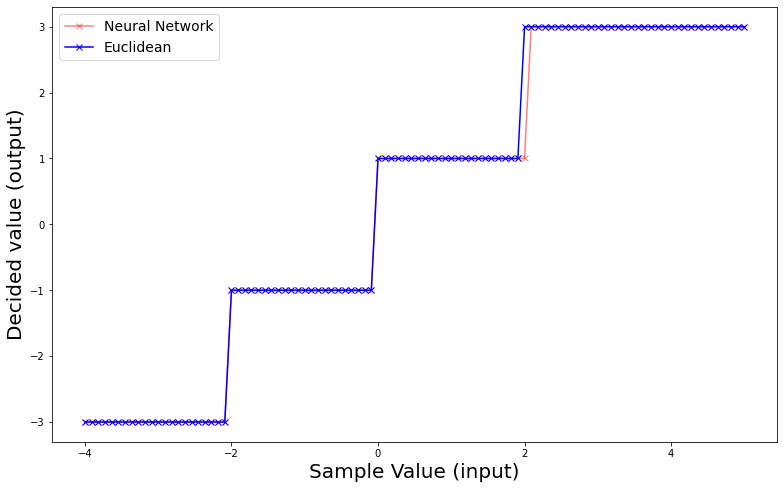

In [10]:
classes = np.array(symbol_set)
test_seq = np.linspace(-4, 4+1, 100)
test_seq = np.array(test_seq, ndmin=2).T

yhat_idx = NN.feedforward(test_seq).argmax(axis=1)
yhat = classes[yhat_idx]
euclid_decisions = CS.decision_making(test_seq)


num = len(test_seq)
plt.figure(figsize=(13,8))
plt.xlabel('Sample Value (input)', fontsize=20)
plt.ylabel('Decided value (output)', fontsize=20)
plt.plot(test_seq[:num], yhat[:num], '-rx', alpha=0.5)
plt.plot(test_seq[:num], euclid_decisions[:num], '-bx', alpha=1)
plt.legend(['Neural Network', 'Euclidean'], fontsize=14)
plt.show()

# Inspect learned filters from Joint Training

### Sender Weights

Cutoff Frequency = 2


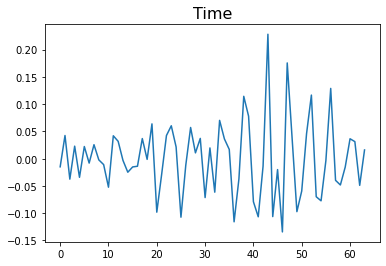

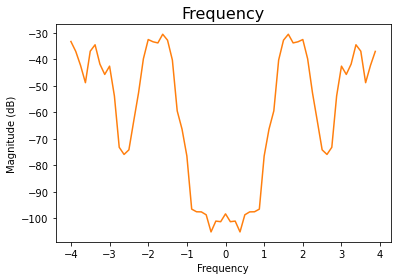

_________________________________________________________

Cutoff Frequency = 1


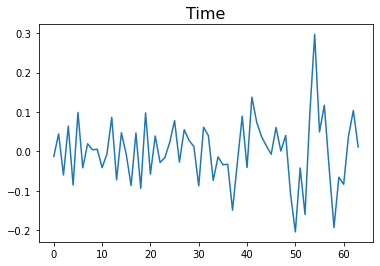

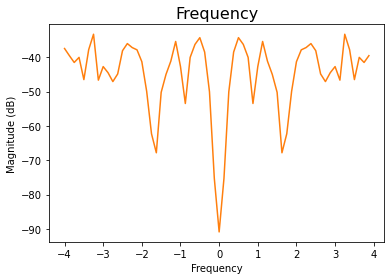

_________________________________________________________

Cutoff Frequency = 0.5


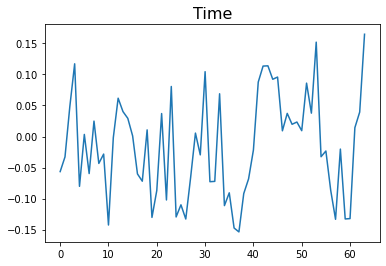

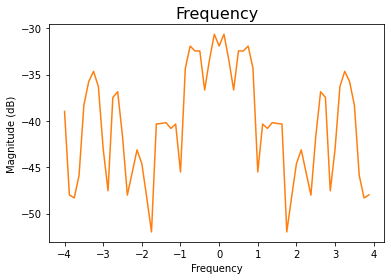

_________________________________________________________

Cutoff Frequency = 0.3


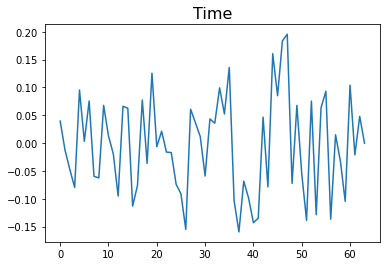

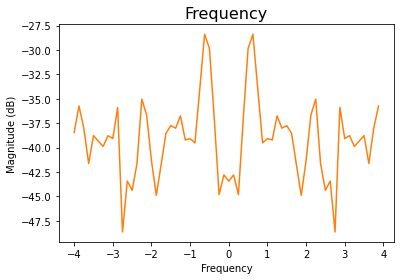

_________________________________________________________

Cutoff Frequency = 0.2


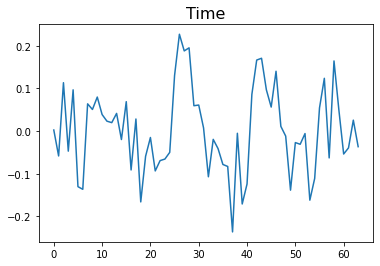

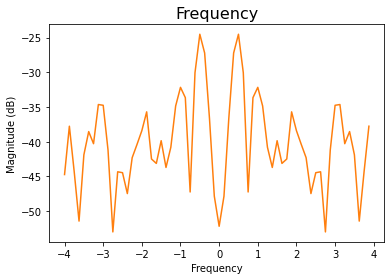

_________________________________________________________



In [19]:
cutoffs = ['2', '1', '05', '03', '02']
cutoff_ints = [2, 1, 0.5, 0.3, 0.2]
#cutoffs = ['1']
#cutoff_ints = [1]

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'Sender_cutoff' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    plt.figure()
    #plt.figure(figsize=(13,8))
    plt.title('Time', fontsize=16)
    plt.plot(learned_filter)
    plt.show()
    plt.figure()
    #plt.figure(figsize=(13,8))
    plt.title('Frequency', fontsize=16)
    plt.magnitude_spectrum(learned_filter, Fs=CS.m, color='C1', sides='twosided', scale='dB')
    plt.show()
    print('_________________________________________________________')
    print()

### Receiver Weights

Cutoff Frequency = 2


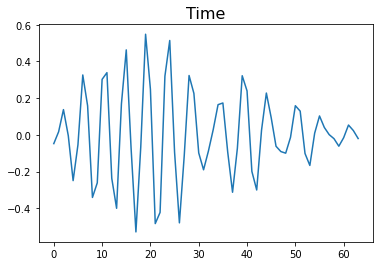

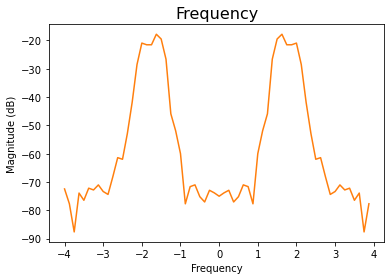

_________________________________________________________

Cutoff Frequency = 1


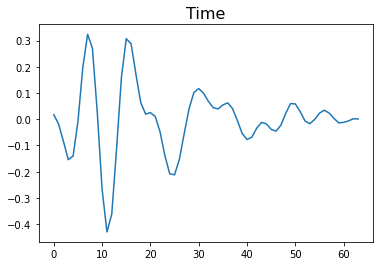

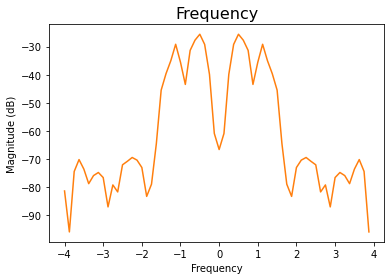

_________________________________________________________

Cutoff Frequency = 0.5


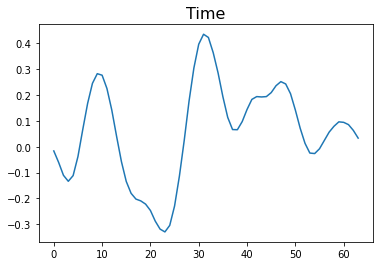

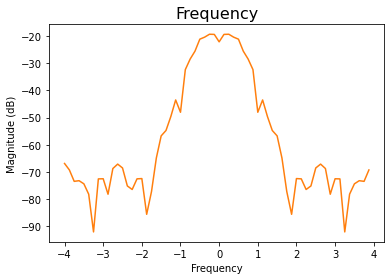

_________________________________________________________

Cutoff Frequency = 0.3


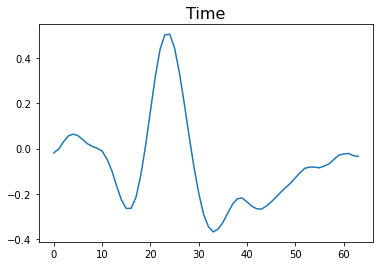

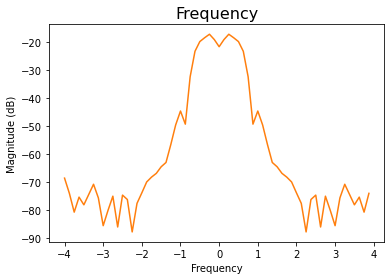

_________________________________________________________

Cutoff Frequency = 0.2


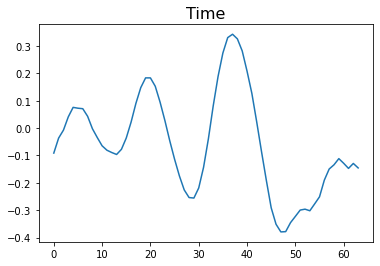

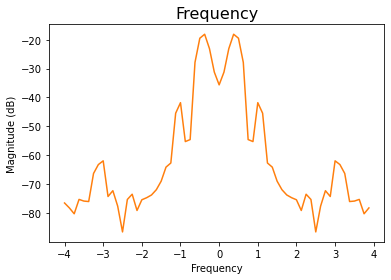

_________________________________________________________



In [20]:
cutoffs = ['2', '1', '05', '03', '02']
cutoff_ints = [2, 1, 0.5, 0.3, 0.2]

for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    path = '../Joint_Models/'
    net = torch.load(path + 'Receiver_cutoff' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    #plt.figure(figsize=(13,8))
    plt.figure()
    plt.title("Time", fontsize=16)
    plt.plot(learned_filter)
    plt.show()
    plt.figure()
    plt.title('Frequency', fontsize=16)
    #plt.figure(figsize=(13,8))
    plt.magnitude_spectrum(learned_filter, Fs=CS.m, color='C1', sides='twosided', scale='dB')
    plt.show()
    print('_________________________________________________________')
    print()

### Total Impulse Response of Sender (i.e. sender filter convolved with LPF)

Cutoff Frequency = 2


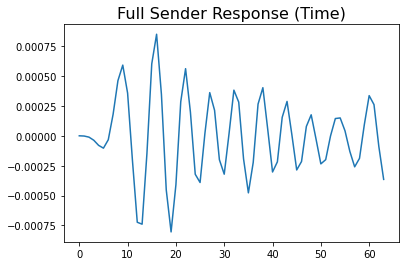

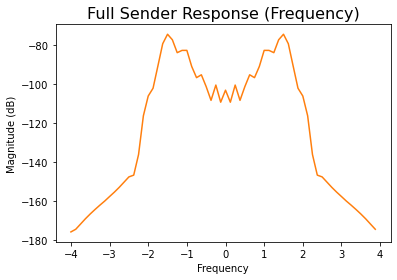

_________________________________________________________

Cutoff Frequency = 1


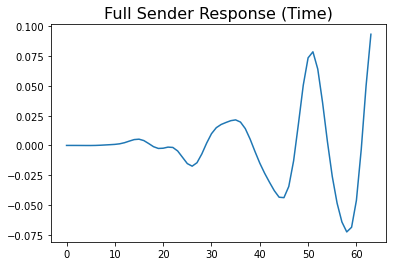

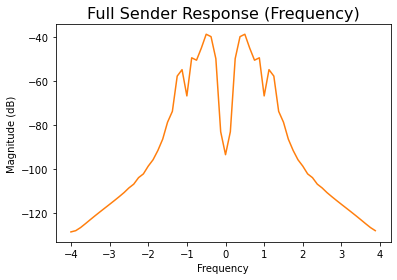

_________________________________________________________

Cutoff Frequency = 0.5


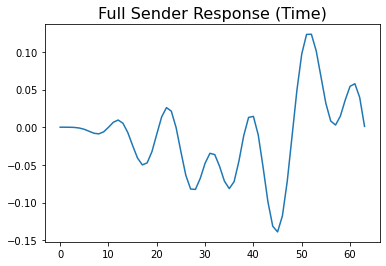

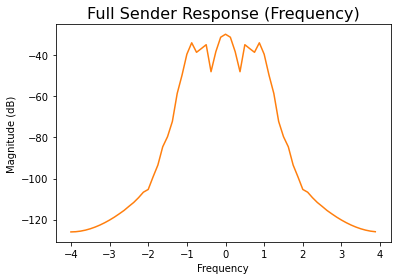

_________________________________________________________

Cutoff Frequency = 0.3


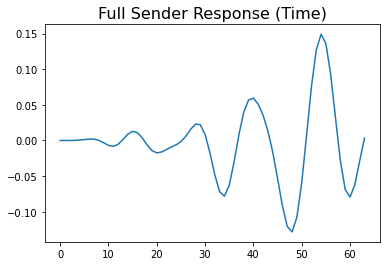

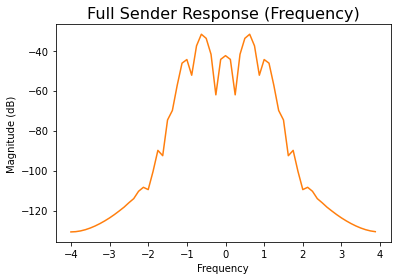

_________________________________________________________

Cutoff Frequency = 0.2


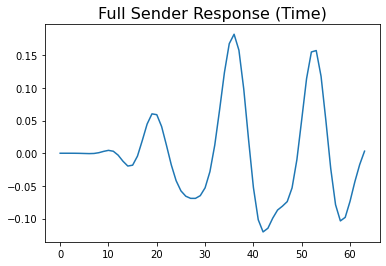

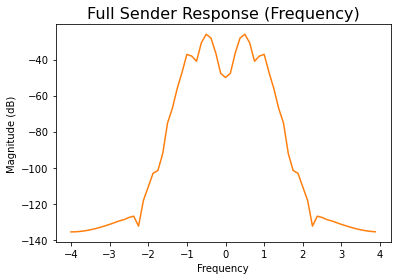

_________________________________________________________



In [23]:
cutoffs = ['2', '1', '05', '03', '02']
cutoff_ints = [2, 1, 0.5, 0.3, 0.2]
#cutoffs = ['03']
#cutoff_ints = [0.3]


for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    b, a = butter_lowpass(cutoff_freq=1, sampling_rate=CS.m, order=10)
    path = '../Joint_Models/'
    net = torch.load(path + 'Sender_cutoff' + cutoff)
    learned_filter = list(net.parameters())[0].detach()[0][0]
    total_sender_response = scipy.signal.lfilter(b, a, learned_filter)
    plt.figure()
    plt.title('Full Sender Response (Time)', fontsize=16)
    plt.plot(total_sender_response)
    plt.show()
    #plt.figure(figsize=(13,8))
    plt.figure()
    plt.title('Full Sender Response (Frequency)', fontsize=16)
    plt.magnitude_spectrum(total_sender_response, Fs=8, scale='dB', sides='twosided', color='C1')
    plt.show()
    print('_________________________________________________________')
    print()

### Total Response of Whole System

Cutoff Frequency = 2


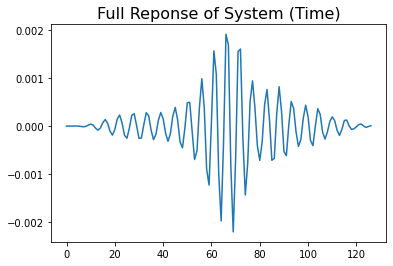

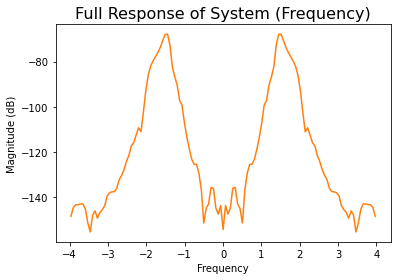

Cutoff Frequency = 1


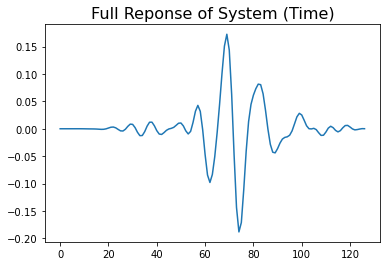

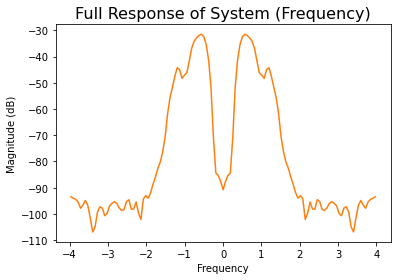

Cutoff Frequency = 0.5


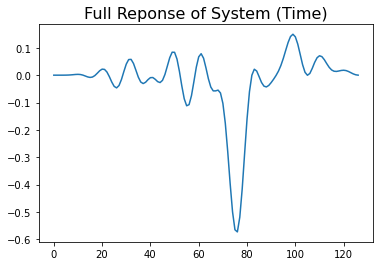

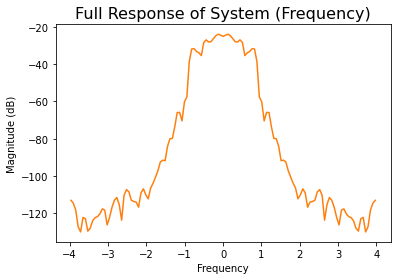

Cutoff Frequency = 0.3


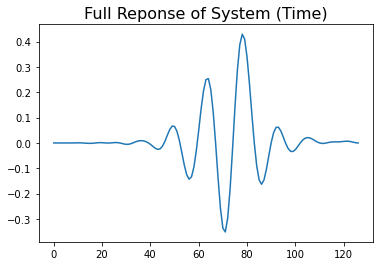

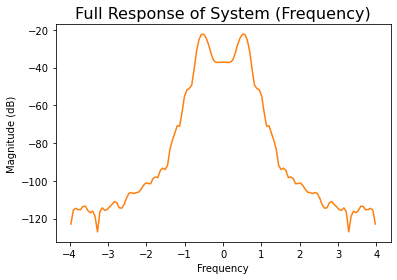

Cutoff Frequency = 0.2


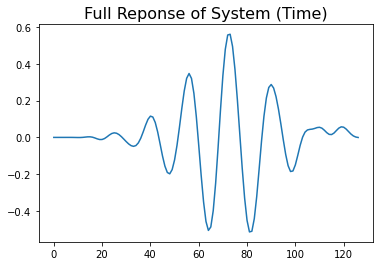

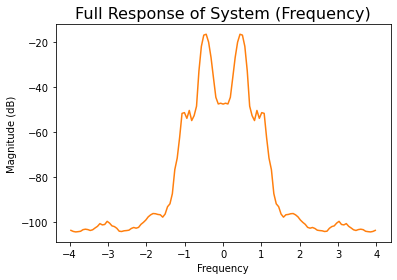

In [24]:
cutoffs = ['2', '1', '05', '03', '02']
cutoff_ints = [2, 1, 0.5, 0.3, 0.2]
#cutoffs = ['03']
#cutoff_ints = [0.3]


for cutoff, c_int in zip(cutoffs, cutoff_ints):
    print('Cutoff Frequency =', c_int)
    b, a = butter_lowpass(cutoff_freq=1, sampling_rate=CS.m, order=10)
    path = '../Joint_Models/'
    tx_net = torch.load(path + 'Sender_cutoff'+cutoff)
    rx_net = torch.load(path + 'Receiver_cutoff'+cutoff)
    learned_tx_filter = list(tx_net.parameters())[0].detach()[0][0]
    learned_rx_filter = list(rx_net.parameters())[0].detach()[0][0]
    total_sender_response = scipy.signal.lfilter(b, a, learned_tx_filter)
    full_response = np.convolve(total_sender_response, learned_rx_filter)
    plt.figure()
    plt.title('Full Reponse of System (Time)', fontsize=16)
    plt.plot(full_response)
    plt.show()
    plt.figure()
    plt.title('Full Response of System (Frequency)', fontsize=16)
    #plt.figure(figsize=(13,8))
    plt.magnitude_spectrum(full_response, Fs=8, scale='dB', sides='twosided', color='C1')
    plt.show()

##### Want to time something? Use following code stump

In [ ]:
# %%timeit -o -r 5